# Comparison of NN Classifiers with Alternative Representations

In this assignment, 5 datasets are selected from [timeseriesclassification](http://www.timeseriesclassification.com/) webpage. Each set will be described under its title. The aim is to built three different representation alternatives _including raw time series observations_ and use four different distance measurements _including euclidean distance_ in nearest neighbor (NN) classification settings in order to find the best fit for each dataset.  
  
Three different values, (1, 3, 5), will be used as the k value of the NN classification settings. As alternative representation approaches, Nonlinear Regression Tree Representation and Wavelet Transform Representation will be calculated with 2 different parameter sets in addition to Raw Time Series Observations.  
  
Euclidean distance, manhattan distance, dynamic time warping distance, and edit distance with real penalty (g=0.05) will be used to calculate the similarities between time series representations.  
  
After the data preparation and manipulation steps, same approaches will be performed for each dataset, therefore, there will be a function defined below in order to make the similar calculations easy. Lastly, all approaches will be evaluated under the cross validation idea with 5-repeats and 10-folds. Hence, the function calculates (3 different k values x 5 representations x 4 distance measures)=60 different approach&parameter combinations by cross vaildation with 5-repeats and 10-folds.   

# Required Packages & Function Definitions

In [1]:
library(farff)
library(data.table)
library(ggplot2)
library(rpart)
library(dtw)
library(wavelets)
library(TSdist)
library(TunePareto)

#for better visualization
options(repr.plot.width=8, repr.plot.height=4)

Warning message:
"package 'farff' was built under R version 3.6.3"Warning message:
"package 'dtw' was built under R version 3.6.3"Loading required package: proxy
Warning message:
"package 'proxy' was built under R version 3.6.3"
Attaching package: 'proxy'

The following objects are masked from 'package:stats':

    as.dist, dist

The following object is masked from 'package:base':

    as.matrix

Loaded dtw v1.22-3. See ?dtw for help, citation("dtw") for use in publication.

Warning message:
"package 'wavelets' was built under R version 3.6.2"Warning message:
"package 'TSdist' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Loaded TSdist v3.7. See ?TSdist for help, citation("TSdist") for use in publication.

Warning message:
"package 'TunePareto' was built under R version 3.6.3"

### Raw Time Series Representation

This function takes the dataset and converts it to the matrix of raw time series observations.  

In [2]:
rawReprFunc <- function(givenTable) {
    myTable <- copy(givenTable)
    maxID <- as.numeric(myTable[which.max(myTable$id)]$id)
    maxTime <- as.numeric(myTable[which.max(myTable$time)]$time)
    
    myMatrix <- matrix(myTable$value, nrow=maxID, ncol=maxTime, byrow=T)
    return(myMatrix) 
}

### Nonlinear Regression Tree Representation

This function takes the dataset and converts it to the matrix of nonlinear regression tree representation.  

In [3]:
nltreeReprFunc <- function(givenTable, maxDepth) {
    myTable <- copy(givenTable)
    maxID <- as.numeric(myTable[which.max(myTable$id)]$id)
    maxTime <- as.numeric(myTable[which.max(myTable$time)]$time)
    
    for (i in (1:maxID)) {
        treeFit <- rpart(value~time+time^2+time^3, myTable[id==i],
                         control=rpart.control(maxdepth=maxDepth, cp=0, minsplit=20, minbucket=10))
        myTable[id==i, treeRep:=predict(treeFit, myTable[id==i])]
    }
    
    myMatrix <- matrix(myTable$treeRep, nrow=maxID, ncol=maxTime, byrow=T)
    return(myMatrix)
}

### Wavelet Transform Representation

This function takes the dataset and converts it to the matrix of wavelet transform representation.  

In [4]:
haarWaveletReprFunc <- function(givenTable, givenMethod) {
    myTable <- copy(givenTable)
    maxID <- as.numeric(myTable[which.max(myTable$id)]$id)
    maxTime <- as.numeric(myTable[which.max(myTable$time)]$time)
    reprValuesVec <- numeric(0)
    
    for (i in (1:maxID)) {
        dwtObject <- dwt(myTable[id==i]$value, filter=givenMethod)
        tempValues <- dwtObject@V[[1]]
        reprValuesVec <- c(reprValuesVec, tempValues)
    }
    
    myMatrix <- matrix(reprValuesVec, nrow=maxID, ncol=maxTime/2, byrow=T)
    return(myMatrix) 
}

### kNN Nearest Neighbor Calculator

Below, two functions are definded to find the k-NN predictions of given representation matrices. getmode() function simply returns the mode value of a vector. kNNCalculator() makes the calculations for the nearest neighbor and returns k-NN predictions as a vector.  

In [5]:
getmode <- function(v) {
    uniqv <- unique(v)
    uniqv[which.max(tabulate(match(v, uniqv)))]
}

kNNCalculator <- function(classVector, distMatrix, k, testIndices)  {
    KNN_neighborhood <- apply(distMatrix, 1, order) 
    KNN_neighborhood <- KNN_neighborhood[, testIndices]
    tempSplit <- split(classVector[KNN_neighborhood[1:k,]], ceiling(seq_along(classVector[KNN_neighborhood[1:k,]])/k))
    KNN_pred <- sapply(tempSplit, getmode)
    return(KNN_pred)
}

### Distance Measurements

These four functions take the representation matrices and calculate the difference between the instances by using euclidean distance, manhattan distance, dynamic time warping distance, and edit distance with real penalty respectively.  

In [6]:
eucDistMatrix <- function(reprMatrix) {
    large_number <- 9999
    eucDist <- as.matrix(dist(reprMatrix))
    diag(eucDist) <- large_number
    return(eucDist)
}

manhattanDistMatrix <- function(reprMatrix) { 
    large_number <- 9999
    manhDist <- as.matrix(dist(reprMatrix, method="manhattan"))
    diag(manhDist) <- large_number
    return(manhDist)
}

dtwDistMatrix <- function(reprMatrix) {
    large_number <- 9999
    dtwDist <- as.matrix(dtwDist(reprMatrix))
    diag(dtwDist) <- large_number
    return(dtwDist)
}

erpDistMatrix <- function(reprMatrix) {
    large_number <- 9999
    erpDist <- as.matrix(TSDatabaseDistances(reprMatrix, distance='erp', g=0.05))
    diag(erpDist) <- large_number
    return(erpDist)
}

### Accuracy Row Calculator

The intended job for accRowCalculator() is simply returning the accuracy values of each approach as a data table row. The function calls kNNCalculator() function from above in order to get the class predictions. Then, it evaluates the accuracy value.  

In [7]:
accRowCalculator <- function(rep, fold, kValue, actualClasses, distMatrix, reprName, p, distName, testIndices) {
    preds <- kNNCalculator(actualClasses, distMatrix, kValue, testIndices)    
    acc <- sum(preds==actualClasses[testIndices])/length(actualClasses[testIndices])
    return(data.table(rep=rep, fold=fold, kNNValue=kValue, representation=reprName, parameter=p, dist=distName, acc=acc))
}

### The Function that Compares Different Methods by Using Different k Parameter Values and Cross Validation

This function will be called whenever all the approaches discussed above are performed over a dataset. It does all the job itself by using all the functions defined above.  
  
The steps for the functions are:  
* Find the raw time series observations representation and calculate its distance measurements.  
* Find the nonlinear regression tree representation with maxDepth=6 and calculate its distance measurements.  
* Find the nonlinear regression tree representation with maxDepth=12 and calculate its distance measurements.  
* Find the discrete wavelet transform representation with filter="haar" and calculate its distance measurements.  
* Find the discrete wavelet transform representation with filter="la8" and calculate its distance measurements.  
* Calculate the accuracy value for each approach over 10-folds, 5-repeats, and 3 different k values.  
* Return the statistics as a data table.  

In [8]:
alternativeComparisonFunc <- function(kVector, dataTable, actualClasses, cvList, nofRep, nofFold) {
    myDT <- copy(dataTable)
    solutionTable <- data.table(rep=NA, fold=NA, kNNValue=NA, representation=NA, parameter=NA, dist=NA, acc=NA)

    #Raw Representation & Distance Measurements
    rawRepr <- rawReprFunc(myDT) 
    eucMatrixRaw <- eucDistMatrix(rawRepr)
    manhMatrixRaw <- manhattanDistMatrix(rawRepr)
    dtwMatrixRaw <- dtwDistMatrix(rawRepr)
    erpMatrixRaw <- erpDistMatrix(rawRepr)    
    #Nonlinear Regression Tree Representation & Distance Measurements
    treeRepr1 <- nltreeReprFunc(myDT, 6)
    treeRepr2 <- nltreeReprFunc(myDT, 12)
    eucMatrixTree1 <- eucDistMatrix(treeRepr1)
    eucMatrixTree2 <- eucDistMatrix(treeRepr2)
    manhMatrixTree1 <- manhattanDistMatrix(treeRepr1)
    manhMatrixTree2 <- manhattanDistMatrix(treeRepr2)
    dtwMatrixTree1 <- dtwDistMatrix(treeRepr1)
    dtwMatrixTree2 <- dtwDistMatrix(treeRepr2)
    erpMatrixTree1 <- erpDistMatrix(treeRepr1)    
    erpMatrixTree2 <- erpDistMatrix(treeRepr2)     
    #Discrete Wavelet Transform Representation & Distance Measurements
    dwtRepr1 <- haarWaveletReprFunc(myDT, "haar")
    dwtRepr2 <- haarWaveletReprFunc(myDT, "la8")
    eucMatrixDwt1 <- eucDistMatrix(dwtRepr1)
    eucMatrixDwt2 <- eucDistMatrix(dwtRepr2)
    manhMatrixDwt1 <- manhattanDistMatrix(dwtRepr1)
    manhMatrixDwt2 <- manhattanDistMatrix(dwtRepr2)
    dtwMatrixDwt1 <- dtwDistMatrix(dwtRepr1)
    dtwMatrixDwt2 <- dtwDistMatrix(dwtRepr2)
    erpMatrixDwt1 <- erpDistMatrix(dwtRepr1) 
    erpMatrixDwt2 <- erpDistMatrix(dwtRepr2) 

    
    for (k in kVector) {
        for (i in 1:nofRep){
            thisRepetition <- cvList[[i]]
            for (j in 1:nofFold) {
                testIndices <- thisRepetition[[j]]
        
                ## For Raw Representation
                #euclidan
                tempRow <- accRowCalculator(i, j, k, actualClasses, eucMatrixRaw, "raw", NA, "euc", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)   
                #manhattan
                tempRow <- accRowCalculator(i, j, k, actualClasses, manhMatrixRaw, "raw", NA, "manh", testIndices)
                solutionTable <- rbind(solutionTable, tempRow) 
                #dtw
                tempRow <- accRowCalculator(i, j, k, actualClasses, dtwMatrixRaw, "raw", NA, "dtw", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                #erp
                tempRow <- accRowCalculator(i, j, k, actualClasses, erpMatrixRaw, "raw", NA, "erp", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                ## For Nonlinear Tree Representation
                #euclidan
                tempRow <- accRowCalculator(i, j, k, actualClasses, eucMatrixTree1, "tree", "6", "euc", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                tempRow <- accRowCalculator(i, j, k, actualClasses, eucMatrixTree2, "tree", "12", "euc", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                #manhattan
                tempRow <- accRowCalculator(i, j, k, actualClasses, manhMatrixTree1, "tree", "6", "manh", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                tempRow <- accRowCalculator(i, j, k, actualClasses, manhMatrixTree2, "tree", "12", "manh", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                #dtw
                tempRow <- accRowCalculator(i, j, k, actualClasses, dtwMatrixTree1, "tree", "6", "dtw", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                tempRow <- accRowCalculator(i, j, k, actualClasses, dtwMatrixTree2, "tree", "12", "dtw", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                #erp
                tempRow <- accRowCalculator(i, j, k, actualClasses, erpMatrixTree1, "tree", "6", "erp", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                tempRow <- accRowCalculator(i, j, k, actualClasses, erpMatrixTree2, "tree", "12", "erp", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
        
                #For Discrete Wavelet Transform Representation
                #euclidan
                tempRow <- accRowCalculator(i, j, k, actualClasses, eucMatrixDwt1, "dwt", "haar", "euc", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                tempRow <- accRowCalculator(i, j, k, actualClasses, eucMatrixDwt2, "dwt", "la8", "euc", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                #manhattan
                tempRow <- accRowCalculator(i, j, k, actualClasses, manhMatrixDwt1, "dwt", "haar", "manh", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                tempRow <- accRowCalculator(i, j, k, actualClasses, manhMatrixDwt2, "dwt", "la8", "manh", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                #dtw
                tempRow <- accRowCalculator(i, j, k, actualClasses, dtwMatrixDwt1, "dwt", "haar", "dtw", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                tempRow <- accRowCalculator(i, j, k, actualClasses, dtwMatrixDwt2, "dwt", "la8", "dtw", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                #erp
                tempRow <- accRowCalculator(i, j, k, actualClasses, erpMatrixDwt1, "dwt", "haar", "erp", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
                tempRow <- accRowCalculator(i, j, k, actualClasses, erpMatrixDwt2, "dwt", "la8", "erp", testIndices)
                solutionTable <- rbind(solutionTable, tempRow)
            }
        }
    }
    
    solutionTable <- solutionTable[-1]
    solutionTable <- solutionTable[, list(meanACC=mean(acc), sdACC=sd(acc)), by=list(kNNValue, representation, parameter, dist)]    
    return(solutionTable)
}

# Dataset #1  |  GunPointMaleVersusFemale Set

There were two actors who hold a gun and point the gun at target in five seconds. Their actions were translated into time series as coordinate information. The task is to classify female (class 1) and male (class 2). Training data has 135 instances with time series length of 150.  

In [9]:
dt1 <- fread("GunPointMaleVersusFemale_TRAIN.txt")
setnames(dt1, "V1", "class")
dt1 <- dt1[order(class)]
dt1[, class:=as.character(class)]
dt1[, id:=as.character(1:.N)]

#melting operations
dt1_long <- melt(dt1, id.vars=c("id", "class"))
dt1_long[, time:=as.numeric(gsub("\\D", "", variable))-1]
dt1_long <- dt1_long[, list(id,class,time,value)]
dt1_long <- dt1_long[order(id,time)]

#actual classes
dt1_classes <- dt1$class

head(dt1_long)

id,class,time,value
1,1,1,333.2450
1,1,2,333.3123
1,1,3,333.1444
1,1,4,333.2401
1,1,5,333.2588
1,1,6,333.2529


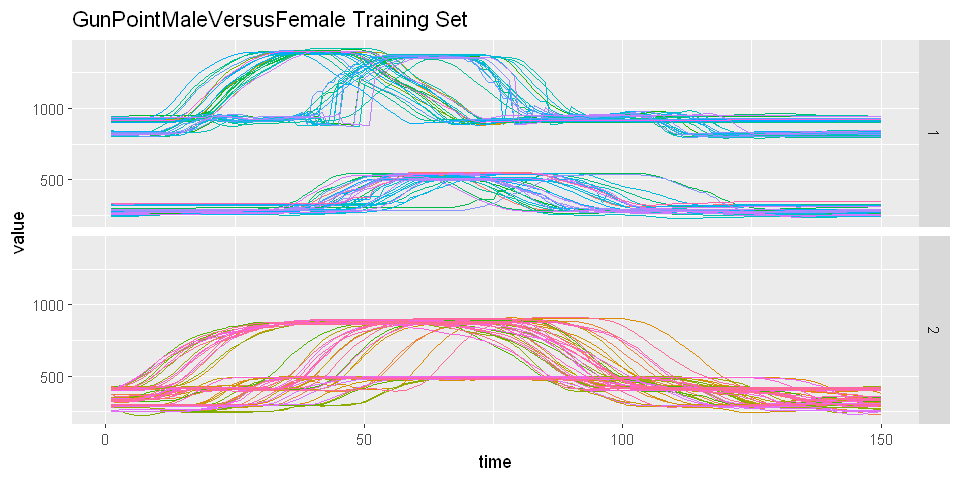

In [10]:
ggplot(dt1_long, aes(time, value)) + geom_line(aes(color=id)) + facet_grid(class~.) + theme(legend.position="none") + 
    labs(title="GunPointMaleVersusFemale Training Set")

Because the instances of class 1 are not aligned over y axis, the mean values will be subtracted from each instance before running the algorithm. 

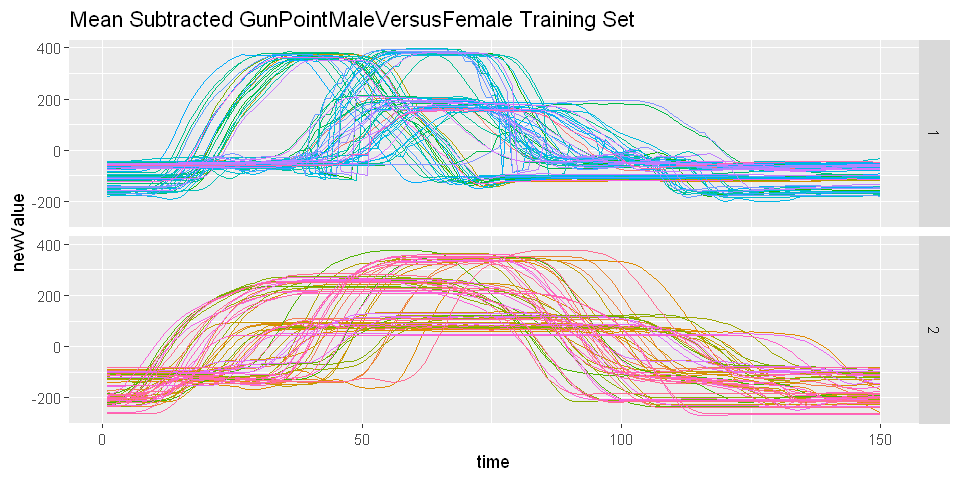

In [11]:
dt1_long[, newValue:=value-mean(value), by=id]

ggplot(dt1_long, aes(time, newValue)) + geom_line(aes(color=id)) + facet_grid(class~.) + theme(legend.position="none") + 
    labs(title="Mean Subtracted GunPointMaleVersusFemale Training Set")

Now, it looks better. But there is one more thing before starting. The algorithm needs "value" as the name of column of observations, therefore, "newValue" will be changed to "value".  

In [12]:
dt1_long[, value:=NULL]
setnames(dt1_long, "newValue", "value")
head(dt1_long)

id,class,time,value
1,1,1,-56.43402
1,1,2,-56.36668
1,1,3,-56.53454
1,1,4,-56.43887
1,1,5,-56.42018
1,1,6,-56.42604


In [13]:
#creating CV indices
set.seed(48)
kVector <- c(1,3,5)
nof_rep <- 5
n_fold <- 10

cv_indices1 <- generateCVRuns(dt1_classes, ntimes=nof_rep, nfold=n_fold,
                              leaveOneOut=FALSE, stratified=TRUE)

In [14]:
#running the algorithm
dt1_reprTable <- alternativeComparisonFunc(kVector, dt1_long, dt1_classes, cv_indices1, nof_rep, n_fold)
dt1_reprTable[order(meanACC, decreasing=T)]

kNNValue,representation,parameter,dist,meanACC,sdACC
1,dwt,haar,euc,1.0000000,0.00000000
1,dwt,la8,euc,1.0000000,0.00000000
1,dwt,haar,manh,1.0000000,0.00000000
1,dwt,la8,manh,1.0000000,0.00000000
1,dwt,haar,dtw,1.0000000,0.00000000
1,dwt,la8,dtw,1.0000000,0.00000000
1,dwt,haar,erp,1.0000000,0.00000000
1,dwt,la8,erp,1.0000000,0.00000000
3,dwt,haar,dtw,1.0000000,0.00000000
3,dwt,la8,dtw,1.0000000,0.00000000


When we look at the ordered results, we can see that there are 12 different approaches who predict 100% correctly. Also, other results show that discrete wavelet transform with any distance measurement and k values of (1, 3, 5) perform over 96% accuracy although the success of other approaches are up to 55%. For the GunPointMaleVersusFemale Set, DWT can be used with any desired distance measurement and any k value in (1, 3, 5) in order to classify.  

# Dataset #2  |  PowerCons Set

This set contains the individual household electric power consumption in one year observed in either a warm season (from April to September) or a cold season (from October to March). The task is to classify warm season (class 1) and cold season (class 2). Training data has 180 instances with time series length of 144.  

In [15]:
dt2 <- fread("PowerCons_TRAIN.txt")
setnames(dt2, "V1", "class")
dt2 <- dt2[order(class)]
dt2[, class:=as.character(class)]
dt2[, id:=as.character(1:.N)]

#melting operations
dt2_long <- melt(dt2, id.vars=c("id", "class"))
dt2_long[, time:=as.numeric(gsub("\\D", "", variable))-1]
dt2_long <- dt2_long[, list(id,class,time,value)]
dt2_long <- dt2_long[order(id,time)]

#actual classes
dt2_classes <- dt2$class

head(dt2_long)

id,class,time,value
1,1,1,0.44
1,1,2,0.40
1,1,3,0.36
1,1,4,0.35
1,1,5,0.35
1,1,6,0.38


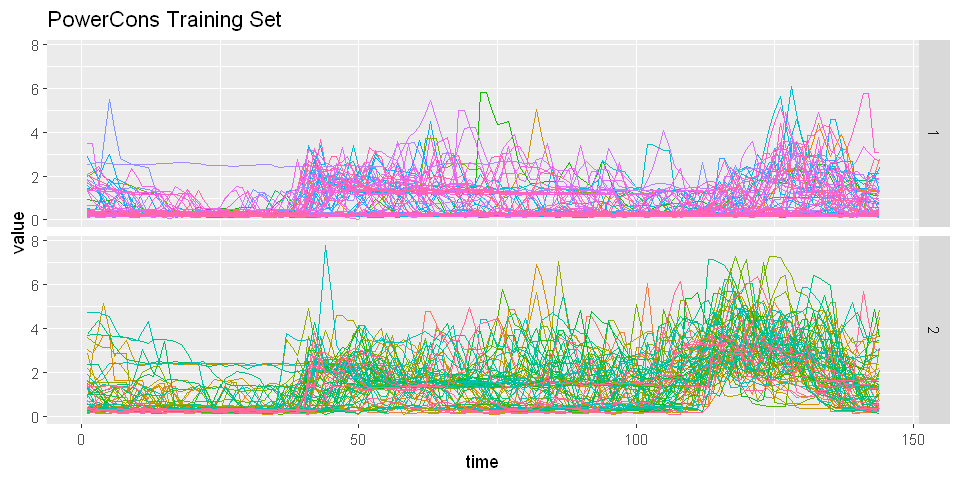

In [16]:
ggplot(dt2_long, aes(time, value)) + geom_line(aes(color=id)) + facet_grid(class~.) + theme(legend.position="none") + 
    labs(title="PowerCons Training Set")

In [17]:
#creating CV indices
set.seed(58)
kVector <- c(1,3,5)
nof_rep <- 5
n_fold <- 10

cv_indices2 <- generateCVRuns(dt2_classes, ntimes=nof_rep, nfold=n_fold,
                              leaveOneOut=FALSE, stratified=TRUE)

In [18]:
#running the algorithm
dt2_reprTable <- alternativeComparisonFunc(kVector, dt2_long, dt2_classes, cv_indices2, nof_rep, n_fold)
dt2_reprTable[order(meanACC, decreasing=T)]

kNNValue,representation,parameter,dist,meanACC,sdACC
3,dwt,haar,euc,0.9722222,0.03928371
3,dwt,la8,euc,0.9722222,0.03928371
5,dwt,haar,euc,0.9722222,0.03928371
5,dwt,la8,euc,0.9722222,0.03928371
5,dwt,haar,manh,0.9555556,0.05264484
5,dwt,la8,manh,0.9555556,0.05264484
3,dwt,haar,manh,0.9500000,0.05527138
1,dwt,la8,euc,0.9500000,0.04236936
1,dwt,haar,euc,0.9444444,0.04761905
3,dwt,la8,manh,0.9444444,0.05382802


Again, discrete wavelet transform works well for this dataset. Over 90% accuracy level, it can be chosen with parameters of first 16 rows of the table.  

# Dataset #3  |  Trace Set

The dataset is a synthetic set created to simulate instrumentation failures in a nuclear power plant. The task is to classify the instances between 4 classes. Training data has 100 instances with time series length of 275.  

In [19]:
dt3 <- fread("Trace_TRAIN.txt")
setnames(dt3, "V1", "class")
dt3 <- dt3[order(class)]
dt3[, class:=as.character(class)]
dt3[, id:=as.character(1:.N)]

#melting operations
dt3_long <- melt(dt3, id.vars=c("id", "class"))
dt3_long[, time:=as.numeric(gsub("\\D", "", variable))-1]
dt3_long <- dt3_long[, list(id,class,time,value)]
dt3_long <- dt3_long[order(id,time)]

#actual classes
dt3_classes <- dt3$class

head(dt3_long)

id,class,time,value
1,1,1,0.5440704
1,1,2,0.6578630
1,1,3,0.6112391
1,1,4,0.5454131
1,1,5,0.5321561
1,1,6,0.5930125


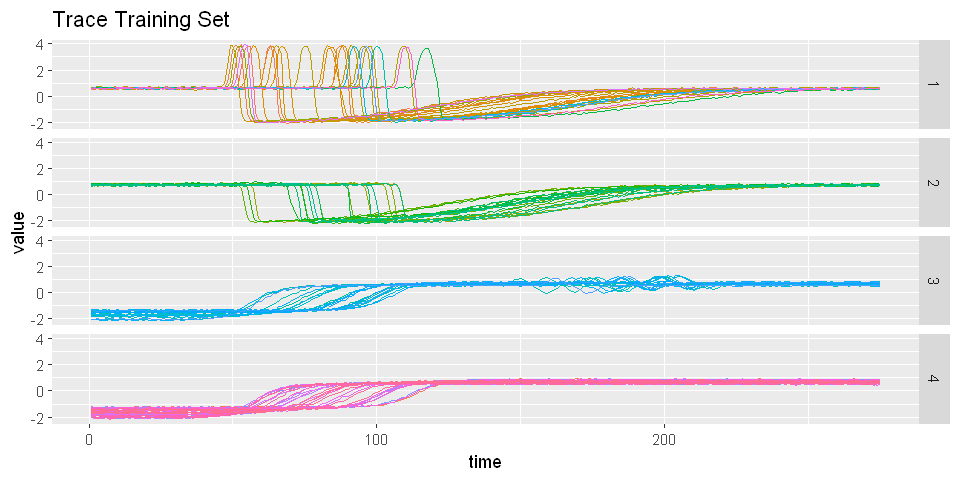

In [20]:
ggplot(dt3_long, aes(time, value)) + geom_line(aes(color=id)) + facet_grid(class~.) + theme(legend.position="none") + 
    labs(title="Trace Training Set")

In [21]:
#creating CV indices
set.seed(68)
kVector <- c(1,3,5)
nof_rep <- 5
n_fold <- 10

cv_indices3 <- generateCVRuns(dt3_classes, ntimes=nof_rep, nfold=n_fold,
                              leaveOneOut=FALSE, stratified=TRUE)

In [22]:
#running the algorithm
dt3_reprTable <- alternativeComparisonFunc(kVector, dt3_long, dt3_classes, cv_indices3, nof_rep, n_fold)
dt3_reprTable[order(meanACC, decreasing=T)]

kNNValue,representation,parameter,dist,meanACC,sdACC
1,dwt,la8,dtw,1.00,0.00000000
1,dwt,haar,dtw,0.99,0.03030458
3,dwt,haar,dtw,0.99,0.03030458
3,dwt,la8,dtw,0.99,0.03030458
5,dwt,haar,dtw,0.94,0.06998542
5,dwt,la8,dtw,0.93,0.07354022
1,dwt,la8,erp,0.90,0.06998542
1,dwt,haar,erp,0.89,0.07071068
1,dwt,haar,manh,0.85,0.07889544
1,dwt,la8,manh,0.85,0.07889544


The best results have been achieved by dwt representation again. The approach and parameter alternatives can be selected by using the top values of the table above.  

# Dataset #4  |  Colposcopy Set

This set represents the change in intensity values of a pixel region from colposcopic images during the colposcopy test. The task is to classify the nature of diagnosis from a colposcopy between 6 classes. Training data has 100 instances with time series length of 180.  

In [23]:
dt4 <- data.table(readARFF("Colposcopy_TRAIN.arff"))
setnames(dt4, "condition", "class")
dt4 <- dt4[order(class)]
dt4[, class:=as.character(class)]
dt4[, id:=as.character(1:.N)]

#melting operations
dt4_long <- melt(dt4, id.vars=c("id", "class"))
dt4_long[, time:=as.numeric(gsub("\\D", "", variable))+1]
dt4_long <- dt4_long[, list(id,class,time,value)]
dt4_long <- dt4_long[order(id,time)]

#actual classes
dt4_classes <- dt4$class

head(dt4_long)

Parse with reader=readr : Colposcopy_TRAIN.arff
Loading required package: readr
header: 0.140000; preproc: 0.010000; data: 0.090000; postproc: 0.000000; total: 0.240000


id,class,time,value
1,0,1,4.4979080
1,0,2,4.4979080
1,0,3,7.7928870
1,0,4,2.1443515
1,0,5,0.7322176
1,0,6,5.9100418


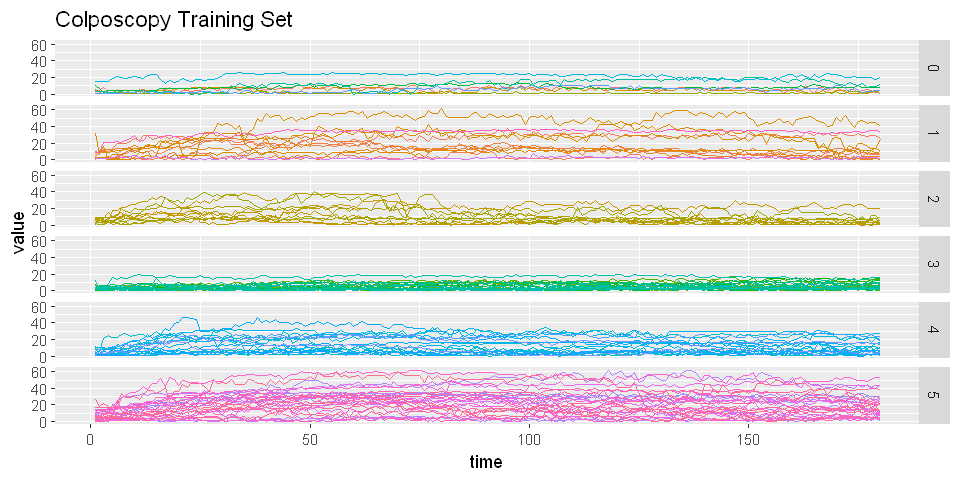

In [24]:
ggplot(dt4_long, aes(time, value)) + geom_line(aes(color=id)) + facet_grid(class~.) + theme(legend.position="none") + 
    labs(title="Colposcopy Training Set")

In [25]:
#creating CV indices
set.seed(78)
kVector <- c(1,3,5)
nof_rep <- 5
n_fold <- 10

cv_indices4 <- generateCVRuns(dt4_classes, ntimes=nof_rep, nfold=n_fold,
                              leaveOneOut=FALSE, stratified=TRUE)

In [26]:
#running the algorithm
dt4_reprTable <- alternativeComparisonFunc(kVector, dt4_long, dt4_classes, cv_indices4, nof_rep, n_fold)
dt4_reprTable[order(meanACC, decreasing=T)]

kNNValue,representation,parameter,dist,meanACC,sdACC
3,dwt,haar,erp,0.4040000,0.1211093
3,dwt,la8,erp,0.3944444,0.1287624
3,tree,6,erp,0.3835556,0.1333190
5,dwt,haar,manh,0.3740000,0.1421253
3,dwt,haar,dtw,0.3737778,0.1195600
3,tree,12,erp,0.3733333,0.1340683
1,dwt,haar,dtw,0.3646667,0.1334408
3,dwt,haar,euc,0.3642222,0.1307052
3,dwt,la8,manh,0.3642222,0.1275442
1,dwt,haar,erp,0.3640000,0.1320719


Using 60 different parameter&method combinations, the best result we obtain is the accuracy level of 0.4040000, which is too low to classify correctly. In order to get a representation with a higher accuracy, some data preprocessing steps will be applied.  
  
As a first method, the mean value will be subtracted from each instance.  

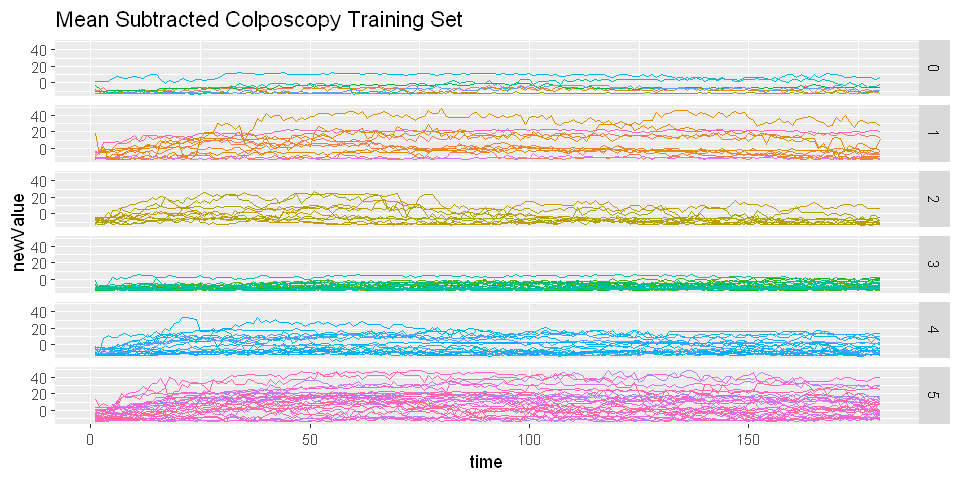

In [27]:
dt4_long_2 <- copy(dt4_long)
dt4_long_2[, newValue:=value-mean(value)]

ggplot(dt4_long_2, aes(time, newValue)) + geom_line(aes(color=id)) + facet_grid(class~.) + theme(legend.position="none") + 
    labs(title="Mean Subtracted Colposcopy Training Set")

Because the algorithm needs "value" as the name of column of observations, "newValue" will be changed to "value".  

In [28]:
dt4_long_2[, value:=NULL]
setnames(dt4_long_2, "newValue", "value")

In [29]:
#running the algorithm again
dt4_reprTable_2 <- alternativeComparisonFunc(kVector, dt4_long_2, dt4_classes, cv_indices4, nof_rep, n_fold)
head(dt4_reprTable_2[order(meanACC, decreasing=T)])

kNNValue,representation,parameter,dist,meanACC,sdACC
1,dwt,la8,erp,0.3840000,0.1355849
3,dwt,la8,erp,0.3742222,0.1353670
5,dwt,haar,manh,0.3740000,0.1421253
3,dwt,haar,dtw,0.3737778,0.1195600
1,dwt,haar,erp,0.3737778,0.1379357
1,dwt,haar,dtw,0.3646667,0.1334408


The best result we obtain is less than 0.4040000. Let's try another approach. Now, lagged values of the observations will be subtracted from each observation and the difference will be used to build models.  

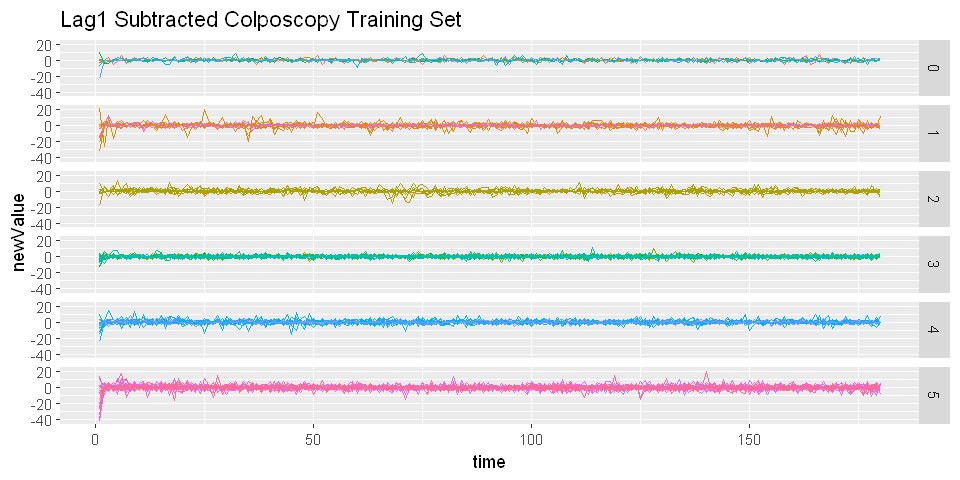

In [30]:
dt4_long_3 <- copy(dt4_long)
dt4_long_3[, newValue:=c(0, diff(value, 1))]

ggplot(dt4_long_3, aes(time, newValue)) + geom_line(aes(color=id)) + facet_grid(class~.) + theme(legend.position="none") + 
    labs(title="Lag1 Subtracted Colposcopy Training Set")

Again, the column name will be changed before running the algorithm.   

In [31]:
dt4_long_3[, value:=NULL]
setnames(dt4_long_3, "newValue", "value")

In [32]:
#running the algorithm again
dt4_reprTable_3 <- alternativeComparisonFunc(kVector, dt4_long_2, dt4_classes, cv_indices4, nof_rep, n_fold)
head(dt4_reprTable_3[order(meanACC, decreasing=T)])

kNNValue,representation,parameter,dist,meanACC,sdACC
1,dwt,la8,erp,0.3840000,0.1355849
3,dwt,la8,erp,0.3742222,0.1353670
5,dwt,haar,manh,0.3740000,0.1421253
3,dwt,haar,dtw,0.3737778,0.1195600
1,dwt,haar,erp,0.3737778,0.1379357
1,dwt,haar,dtw,0.3646667,0.1334408


The data manipulations cannot help us get a better accuracy value. The accuracy value of 0.4040000 is still the best we got. It was obtained by dwt representation using "haar" method, erp distance, and k value of 3.  

# Dataset #5  |  Plane Set

The dataset consists of outlines of planes for 6 different plane types. The task is to classify the planes. Training data has 105 instances with time series length of 144.  

In [33]:
dt5 <- fread("Plane_TRAIN.txt")
setnames(dt5, "V1", "class")
dt5 <- dt5[order(class)]
dt5[, class:=as.character(class)]
dt5[, id:=as.character(1:.N)]

#melting operations
dt5_long <- melt(dt5, id.vars=c("id", "class"))
dt5_long[, time:=as.numeric(gsub("\\D", "", variable))-1]
dt5_long <- dt5_long[, list(id,class,time,value)]
dt5_long <- dt5_long[order(id,time)]

#actual classes
dt5_classes <- dt5$class

head(dt5_long)

id,class,time,value
1,1,1,2.483940
1,1,2,2.276286
1,1,3,2.067516
1,1,4,1.921893
1,1,5,1.718775
1,1,6,1.508428


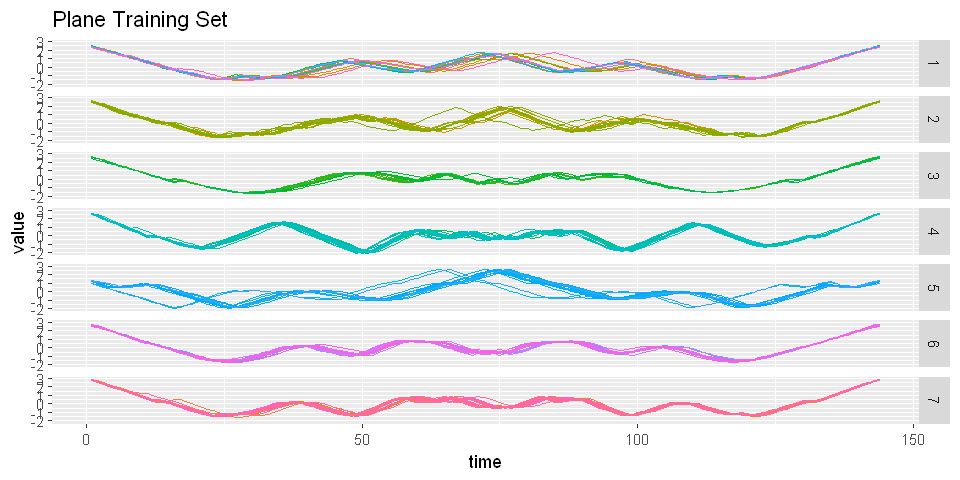

In [34]:
ggplot(dt5_long, aes(time, value)) + geom_line(aes(color=id)) + facet_grid(class~.) + theme(legend.position="none") + 
    labs(title="Plane Training Set")

In [35]:
#creating CV indices
set.seed(88)
kVector <- c(1,3,5)
nof_rep <- 5
n_fold <- 10

cv_indices5 <- generateCVRuns(dt5_classes, ntimes=nof_rep, nfold=n_fold,
                              leaveOneOut=FALSE, stratified=TRUE)

In [36]:
#running the algorithm
dt5_reprTable <- alternativeComparisonFunc(kVector, dt5_long, dt5_classes, cv_indices5, nof_rep, n_fold)
dt5_reprTable[order(meanACC, decreasing=T)]

kNNValue,representation,parameter,dist,meanACC,sdACC
1,dwt,haar,dtw,1.0000000,0.00000000
1,dwt,la8,dtw,1.0000000,0.00000000
3,dwt,haar,dtw,1.0000000,0.00000000
3,dwt,la8,dtw,1.0000000,0.00000000
5,dwt,haar,dtw,1.0000000,0.00000000
5,dwt,la8,dtw,1.0000000,0.00000000
5,dwt,haar,erp,1.0000000,0.00000000
5,dwt,la8,erp,1.0000000,0.00000000
1,dwt,haar,erp,0.9905455,0.02868690
1,dwt,la8,erp,0.9905455,0.02868690


There are 8 different combinations of dwt and distance measurements that have the accuracy value of 1. Any of them can be used to represent the dataset. Again, the best results were obtained by discrete wavelet transform representation.  

# Conclusion

5 different datasets were chosen to be classify by three different representations using 4 different distance measurements in this assignment. Raw time series observations, nonlinear regression trees, and discrete wavelet transforms were the representation approaches. As distance measurements, euclidean distance, manhattan distance, dynamic time warping distance, and edit distance with real penalty were used. Also, three different k values of KNN approach were used under 5-repeats and 10-folds cross validation.  
  
In general, DWT was the best representation approach no matter what the distance measurement was. It reached 100% accuracy for some datasets. Although we could not obtain a good result for the colposcopy set, the models used for representations worked well for other sets.  